In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

CHANDRU M 212222230026

In [3]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [4]:
root = '/content/drive/MyDrive/train_test'

train_data = datasets.ImageFolder(os.path.join(root, 'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'Test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Cat', 'Dog']
Training images available: 88
Testing images available:  20


In [5]:
VGG19model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 96.5MB/s]


In [6]:

# Freeze feature parameters
for param in VGG19model.parameters():
    param.requires_grad = False

In [7]:
# Modify the classifier

torch.manual_seed(42)
VGG19model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 2),
    nn.LogSoftmax(dim=1)
)


In [9]:
print("CHANDRU M 212222230026\n")
for param in VGG19model.parameters():
    print(param.numel())

CHANDRU M 212222230026

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
25690112
1024
2048
2


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG19model.classifier.parameters(), lr=0.001)

In [11]:
# Set time tracking
import time
start_time = time.time()

epochs = 3
max_trn_batch = 88  # As per your dataset size
max_tst_batch = 20  # As per your test dataset size

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1

        # Apply the model
        y_pred = VGG19model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')


    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = VGG19model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed


Duration: 304 seconds


In [12]:
print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

epoch:  2  batch:    9 [    90/8000]  loss: 0.00000000  accuracy:  97.778%


In [13]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')

[tensor(19), tensor(20), tensor(20)]
Test accuracy: 100.000%


In [14]:
# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

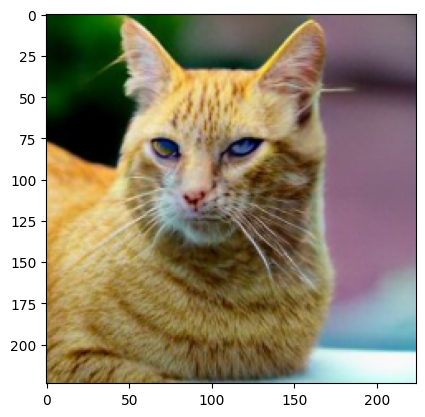

In [16]:
image_index = 2
im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
plt.show()



In [18]:
# VGG19 Model Prediction:

VGG19model.eval()
with torch.no_grad():
    new_pred = VGG19model(test_data[image_index][0].view(1,3,224,224)).argmax()

class_names[new_pred.item()]

print("Chandru M 212222230026")

Chandru M 212222230026
